In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

monthly = pd.read_csv('cargor_model_monthly.csv')

# serialize month
monthly['Month Val'] = pd.to_datetime(monthly['Month'], format='%Y %b')

monthly['Month Num'] = monthly['Month Val'].dt.month
monthly['Year'] = monthly['Month Val'].dt.year

# Calculate the numerical representation based on the order of months
monthly['Month Rank'] = monthly['Month Val'].rank(ascending=True, method='first')

# x = input features (month)
# y = target variable (cargo)

features = ['Total Cargo (Thousand Tonnes)']
X = monthly['Total Cargo (Thousand Tonnes)']
y = monthly['Month Rank']

forecast_range = 12
split_index = 343-forecast_range+1
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

actual_train = monthly.iloc[:split_index]
actual_test = monthly.iloc[split_index:]

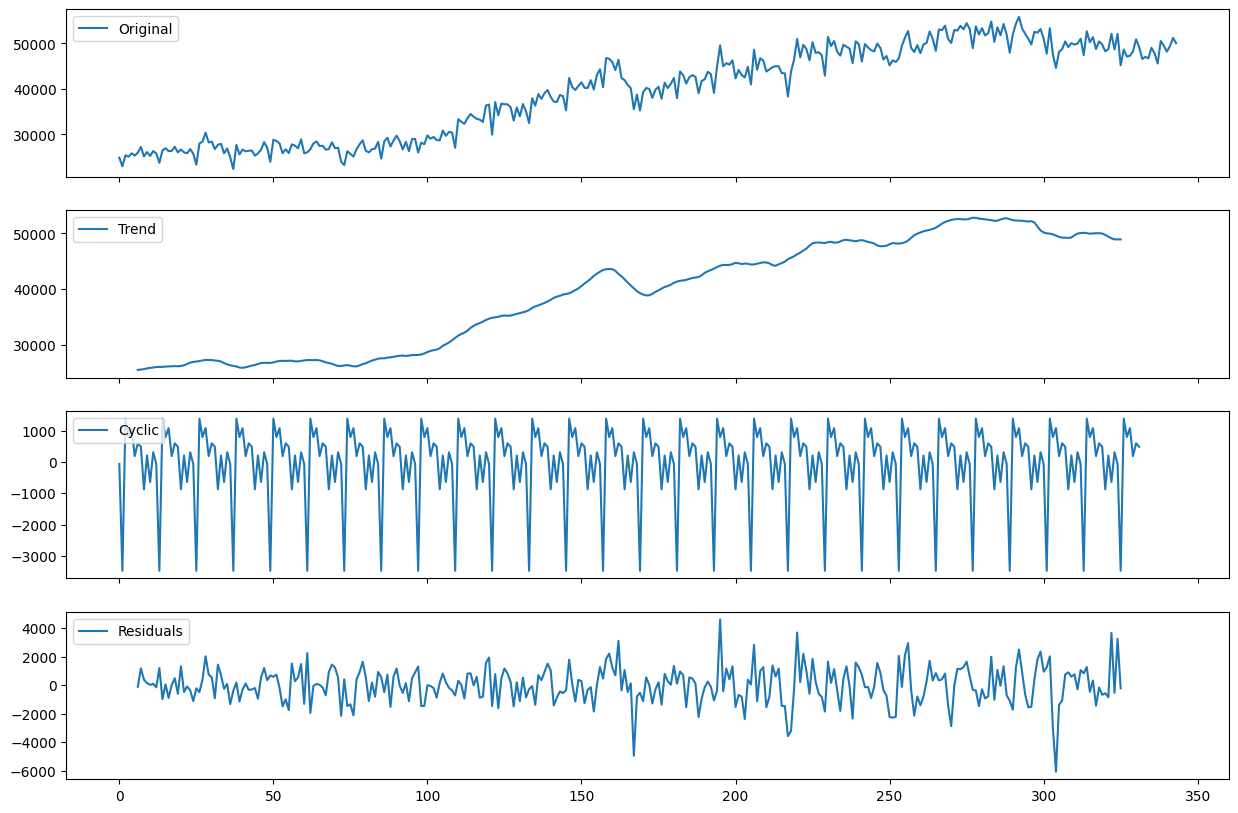

In [2]:
# Decompose
from statsmodels.tsa.seasonal import seasonal_decompose

ts_dicomposition = seasonal_decompose(x=X_train, model='additive', period=12)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(monthly['Total Cargo (Thousand Tonnes)'], label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(seasonal_estimate, label='Cyclic')
axes[2].legend(loc='upper left')

axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left')

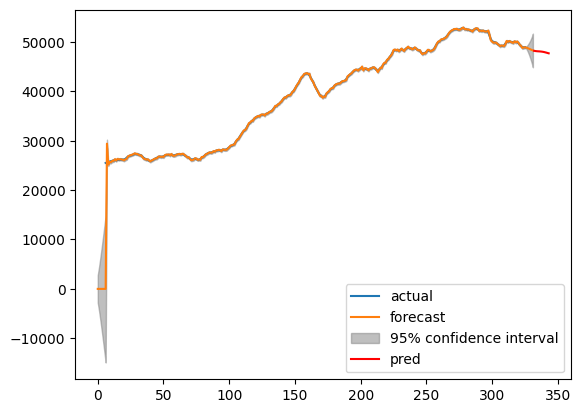

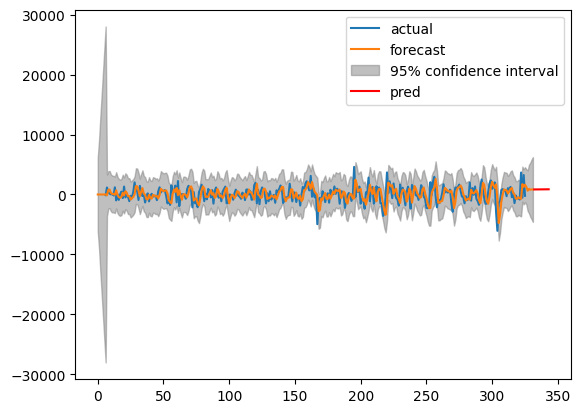

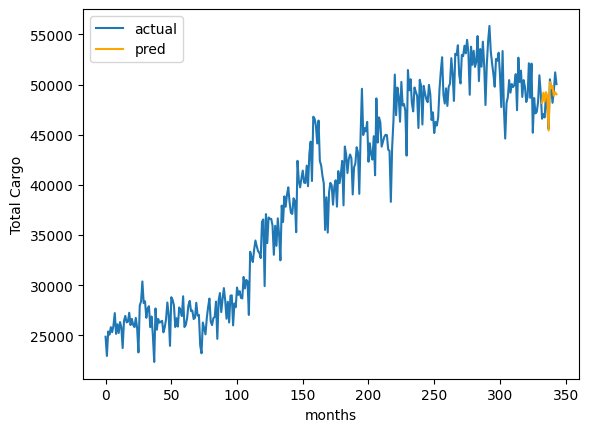

MASE= 0.6221292706585362


In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

trend_model = ARIMA(trend_estimate, order=(2, 2, 3))

trend_fit = trend_model.fit()
trend_pred = pd.Series(trend_fit.forecast(forecast_range))
fig, ax = plt.subplots()
ax = trend_estimate.plot(ax=ax, label='actual')
plot_predict(trend_fit, ax=ax)
plt.plot(trend_pred, label='pred', color='red')
plt.legend()
plt.show()

residual_model = ARIMA(residual_estimate, order=(1, 2, 1))

residual_fit = residual_model.fit()
residual_pred = pd.Series(residual_fit.forecast(forecast_range))
fig, ax = plt.subplots()
ax = residual_estimate.plot(ax=ax, label='actual')
plot_predict(residual_fit, ax=ax)
plt.plot(residual_pred, label='pred', color='red')
plt.legend()
plt.show()

start_month_forecast = actual_train.iloc[-1]['Month Num'] + 1

n_steps = start_month_forecast+forecast_range-1 # Replace with the desired number of forecasted periods
period_length = 12
seasonal_pattern = seasonal_estimate[:12]
seasonal_pred = np.tile(seasonal_pattern.values, n_steps // period_length + 1)[start_month_forecast-1:n_steps]

overall_forecast = trend_pred + seasonal_pred + residual_pred
fig, ax = plt.subplots()

ax = X.plot(ax=ax, label='actual')
plt.plot(overall_forecast, label='pred', color='orange')
plt.xlabel("months")
plt.ylabel("Total Cargo")
plt.legend()
plt.show()

n = np.array(X_test).shape[0]
d = np.abs(np.diff(np.array(X_test))).sum()/(n-1)

errors = np.abs(X_test - overall_forecast)
print('MASE=',errors.mean()/d)

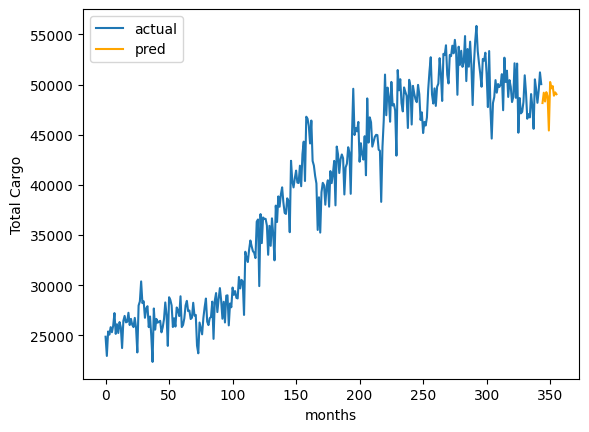

In [4]:
# actual prediction
actual_forecast_range = 12
actual_trend_pred = pd.Series(trend_fit.forecast(actual_forecast_range)).reset_index(drop=True)
actual_residual_pred = pd.Series(residual_fit.forecast(actual_forecast_range)).reset_index(drop=True)

start_month_forecast = monthly.iloc[-1]['Month Num'] + 1
n_steps = start_month_forecast+forecast_range-1
period_length = 12
seasonal_pattern = seasonal_estimate[:12]
actual_seasonal_pred = np.tile(seasonal_pattern.values, n_steps // period_length + 1)[start_month_forecast-1:n_steps]

actual_forecast = actual_trend_pred + actual_seasonal_pred + actual_residual_pred
start_index = monthly.index[-1] + 1
actual_forecast.index = range(start_index, start_index+len(actual_forecast))
fig1, ax1 = plt.subplots()
ax1 = X.plot(ax=ax1, label='actual')
plt.plot(actual_forecast, label='pred', color='orange')
plt.xlabel("months")
plt.ylabel("Total Cargo")
plt.legend()
plt.show()